# Load Dataset

In [1]:
!pip install silence_tensorflow

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-py3-none-any.whl size=3736 sha256=a25ddacc1e16306d85dbda9a1375410b96b49ac61a3a140180403777e61f2ed9
  Stored in directory: /Users/jk/Library/Caches/pip/wheels/88/04/c6/fcafce702ada2f7647cc4209a5bab0cdef5ff7b5b3a8be068c
Successfully built silence-tensorflow


In [2]:
import pandas as pd
import numpy as np

import matplotlib as npl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프 그리기
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [3]:
# parse_dates로 datetime을 date 형태로 가져오기.
raw_data = pd.read_csv("/Users/jk/git/Study/Data/kaggle_dataset/bike_demand/train.csv", parse_dates=["datetime"])
raw_data.shape

(10886, 12)

In [4]:
raw_data["year"] = raw_data["datetime"].dt.year
raw_data["month"] = raw_data["datetime"].dt.month
raw_data["hour"] = raw_data["datetime"].dt.hour
raw_data["dayofweek"] = raw_data["datetime"].dt.dayofweek
raw_data.pop("datetime")
raw_data.shape

(10886, 15)

In [5]:
raw_data.isnull().sum()    # 이상무

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
hour          0
dayofweek     0
dtype: int64

In [6]:
# 데이터 전처리
# data_1 : windspeed == 0 값 제외. 잡음으로 판단.
data_1 = raw_data.loc[raw_data['windspeed'] != 0]


<AxesSubplot:xlabel='workingday', ylabel='count'>

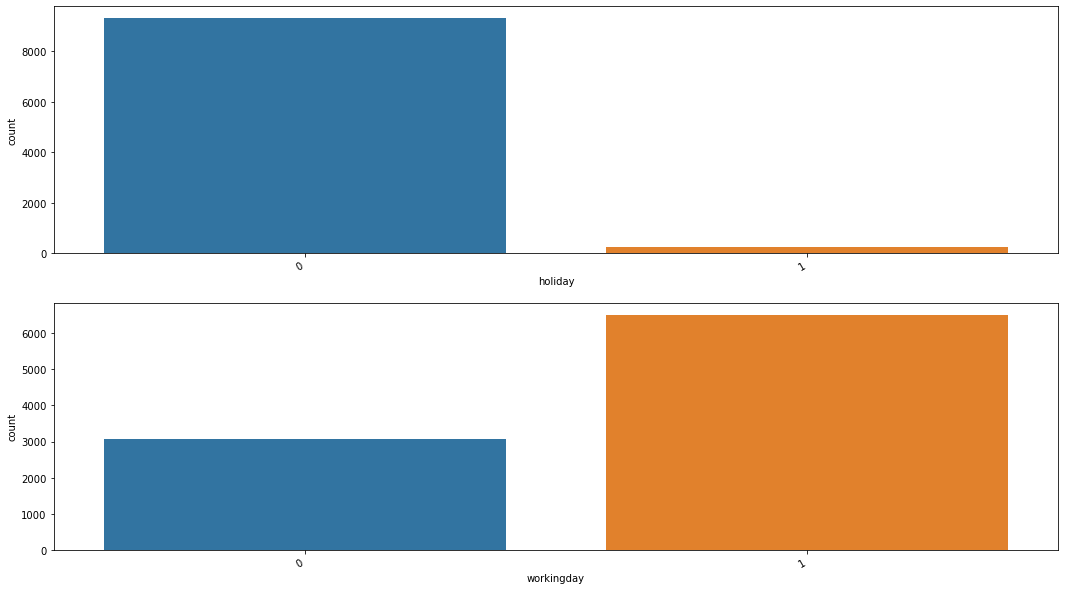

In [7]:


# 풍속 데이터 시각화. windspeed 풍속에 0 값이 가장 많다 -> 데이터가 잘못되어졌을 가능성이 있다.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18, 10)

# axes[0]에 이미지 넣기
plt.sca(axes[0])
plt.xticks(rotation=30, ha="right")    # rotation = 30 은 글씨가 30도로 기울어져 보이게 해서 글씨가 겹치는 것을 방지하는 효과를 준다.
axes[0].set(ylabel='Count')
sns.countplot(data=data_1, x="holiday", ax=axes[0])

# axes[1]에 이미지 넣기
plt.sca(axes[1])
plt.xticks(rotation=30, ha="right")
axes[1].set(ylabel='Count')
sns.countplot(data=data_1, x="workingday", ax=axes[1])

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'count per hour')]

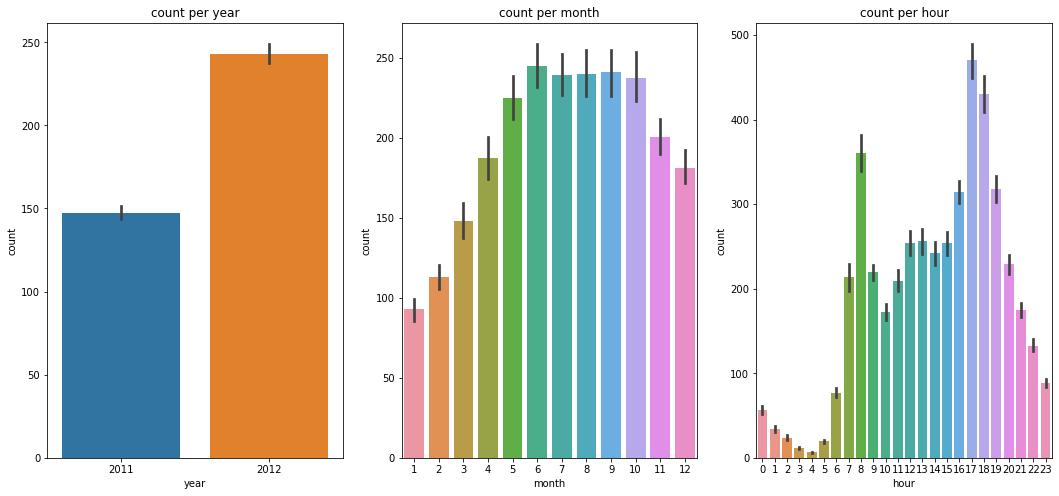

In [8]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18, 8)

sns.barplot(data=data_1, x="year", y="count" , ax=ax1)
sns.barplot(data=data_1, x="month", y="count" , ax=ax2)
sns.barplot(data=data_1, x="hour", y="count" , ax=ax3)

ax1.set(xlabel="year", title="count per year")
ax2.set(xlabel="month", title="count per month")
ax3.set(xlabel="hour", title="count per hour")

In [29]:
train, test = train_test_split(data_1, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), "훈련 샘플")
print(len(val), "검증 샘플")
print(len(test), "테스트 샘플")

6126 훈련 샘플
1532 검증 샘플
1915 테스트 샘플


pandas.core.series.Series

In [10]:
# pd -> tensor
def pd_to_tensor(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('count')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [11]:
# 샘플용 테스트 데이터 만들기
batch_size = 5
train_ds = pd_to_tensor(train, batch_size=batch_size)

In [12]:
example_batch = next(iter(train_ds))[0]

def demo(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [13]:
feature_columns = []

# 범주형 열
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]
for categori in categorical_feature_names:
    categori_column = tf.feature_column.categorical_column_with_vocabulary_list(key=categori, vocabulary_list=train[categori].unique())
    categori_one_hot = tf.feature_column.indicator_column(categori_column)
#     print(categori)
#     demo(categori_one_hot)
    feature_columns.append(categori_one_hot)
    
# 수치형 열
num_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
for header in num_columns:
    num_column = tf.feature_column.numeric_column(key=header)
    feature_columns.append(num_column)
#     print(header)
#     demo(num_column)



In [14]:
# 특성 층 만들기

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 32

train_ds = pd_to_tensor(train, batch_size=batch_size)
val_ds = pd_to_tensor(val, shuffle=False, batch_size=batch_size)
test_ds = pd_to_tensor(test, shuffle=False, batch_size=batch_size)

In [15]:
# 모델 생성, 컴파일, 훈련
def build_model():
    model = tf.keras.Sequential([
                                feature_layer,
                                tf.keras.layers.Dense(64, activation='relu'),
                                tf.keras.layers.Dense(32, activation='relu'),
                                tf.keras.layers.Dense(16, activation='relu'),
                                tf.keras.layers.Dense(8, activation='relu'),
                                tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.0001)
    
    model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mse', 'acc'])
    return model

In [20]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

epoch = 100
model = build_model()
history = model.fit(train_ds,
         validation_data=val_ds,
         verbose=1,
         epochs=epoch,
         callbacks=[earlystop])

Epoch 1/100
192/192 [==============================] - 2s 3ms/step - loss: 63984.7539 - mse: 63984.7539 - acc: 0.0093 - val_loss: 44491.9062 - val_mse: 44491.9062 - val_acc: 0.0085
Epoch 2/100
192/192 [==============================] - 0s 2ms/step - loss: 27345.5508 - mse: 27345.5508 - acc: 0.0108 - val_loss: 9937.2891 - val_mse: 9937.2891 - val_acc: 0.0085
Epoch 3/100
192/192 [==============================] - 0s 2ms/step - loss: 3814.7300 - mse: 3814.7300 - acc: 0.0108 - val_loss: 878.6654 - val_mse: 878.6654 - val_acc: 0.0085
Epoch 4/100
192/192 [==============================] - 0s 2ms/step - loss: 349.0323 - mse: 349.0323 - acc: 0.0108 - val_loss: 93.6114 - val_mse: 93.6114 - val_acc: 0.0085
Epoch 5/100
192/192 [==============================] - 0s 2ms/step - loss: 46.7477 - mse: 46.7477 - acc: 0.0108 - val_loss: 31.3184 - val_mse: 31.3184 - val_acc: 0.0085
Epoch 6/100
192/192 [==============================] - 0s 2ms/step - loss: 18.3936 - mse: 18.3936 - acc: 0.0108 - val_loss: 1

192/192 [==============================] - 0s 2ms/step - loss: 0.1356 - mse: 0.1356 - acc: 0.0106 - val_loss: 0.1185 - val_mse: 0.1185 - val_acc: 0.0085
Epoch 51/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1272 - mse: 0.1272 - acc: 0.0104 - val_loss: 0.1282 - val_mse: 0.1282 - val_acc: 0.0085
Epoch 52/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1195 - mse: 0.1195 - acc: 0.0104 - val_loss: 0.1095 - val_mse: 0.1095 - val_acc: 0.0085
Epoch 53/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1162 - mse: 0.1162 - acc: 0.0106 - val_loss: 0.1104 - val_mse: 0.1104 - val_acc: 0.0085
Epoch 54/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1073 - mse: 0.1073 - acc: 0.0108 - val_loss: 0.1589 - val_mse: 0.1589 - val_acc: 0.0085
Epoch 55/100
192/192 [==============================] - 0s 2ms/step - loss: 0.1052 - mse: 0.1052 - acc: 0.0106 - val_loss: 0.1116 - val_mse: 0.1116 - val_acc: 0.0085
Epoch 56/100
192/

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,acc,val_loss,val_mse,val_acc,epoch
71,0.047249,0.047249,0.010774,0.055858,0.055858,0.008486,71
72,0.040846,0.040846,0.010774,0.030165,0.030165,0.008486,72
73,0.046286,0.046286,0.010774,0.033675,0.033675,0.008486,73
74,0.057323,0.057323,0.010774,0.061551,0.061551,0.008486,74
75,0.052138,0.052138,0.010774,0.047455,0.047455,0.008486,75


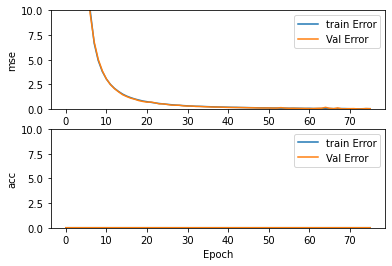

In [22]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.subplot(2,1,1)  
    plt.xlabel('Epoch')
    plt.ylabel("mse")
    plt.plot(hist['epoch'], hist['mse'],
            label="train Error")
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0, 10])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel("acc")
    plt.plot(hist['epoch'], hist['acc'],
            label="train Error")
    plt.plot(hist['epoch'], hist['val_acc'],
             label = 'Val Error')
    plt.ylim([0, 10])
    plt.legend()
    
    plt.show()

plot_history(history)

In [38]:
# https://www.youtube.com/watch?v=Q_MbN-vu_2w&list=PLaTc2c6yEwmo4hpZKEGi05UFN0tpwHVG1&index=6
# 위 사이트에 공식 및 추가 내용이 있음. 궁금하면 확인요망
def rmsle(predicted_values, actual_values):
        
    # to numpy
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # log1p
    log_predict = np.log1p(predicted_values)
    log_actual = np.log1p(actual_values)
    
    # cal diff
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # mean
    mean_difference = difference.mean()
    print(mean_difference)
    
    # root
    score = np.sqrt(mean_difference)
    
    return score

In [39]:
pred = model.predict(test_ds)
print ("RMSLE Value For Tensorflow: ",
         rmsle(pred, test['count']))

3.883162829317116
RMSLE Value For Tensorflow:  1.9705742384688572
